In [55]:
import os, sys
import glob
import iris
from iris.experimental.equalise_cubes import equalise_attributes
import iris.plot as iplt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break
modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)
import general_io as gio
import spatial_weights
import convenient_universal as uconv
import timeseries

## Find files

In [56]:
def find_thetao_files(model, experiment, rip):
    """Find thetao files for given model, experiment and rip"""

    search_pattern = '/g/data/ua6/DRSv2/CMIP5/%s/%s/mon/ocean/%s/thetao/latest/thetao_Omon_*.nc' %(model, experiment, rip)
    file_list = glob.glob(search_pattern)
    
    return file_list


def find_ohc_files(model, experiment, rip):
    """Find ohc files for given model, experiment and rip"""

    search_pattern = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/%s/ohc/latest/ohc_Oyr_*.nc' %(model, experiment, rip)
    file_list = glob.glob(search_pattern)
    
    return file_list


def find_volume_file(model, experiment, rip='r0i0p0'):
    """Find files for given model, experiment and rip"""

    search_pattern = '/g/data/ua6/DRSv2/CMIP5/%s/%s/fx/ocean/%s/volcello/latest/*.nc' %(model, experiment, rip)
    volume_file = glob.glob(search_pattern)
    
    return volume_file[0]

In [20]:
files = {}
files['historical'] = find_thetao_files('CanESM2', 'historical', 'r1i1p1')
files['historicalGHG'] = find_thetao_files('CanESM2', 'historicalGHG', 'r1i1p1')
files['historicalMisc'] = find_thetao_files('CanESM2', 'historicalMisc', 'r1i1p4')
files['piControl'] = find_thetao_files('CanESM2', 'piControl', 'r1i1p1')

In [ ]:
volume_file = find_volume_file('CanESM2', 'historical')

In [57]:
files = {}
files['historical'] = find_ohc_files('CanESM2', 'historical', 'r1i1p1')
files['historicalGHG'] = find_ohc_files('CanESM2', 'historicalGHG', 'r1i1p1')
files['historicalMisc'] = find_ohc_files('CanESM2', 'historicalMisc', 'r1i1p4')
files['piControl'] = find_ohc_files('CanESM2', 'piControl', 'r1i1p1')

## Load data

In [50]:
def load_thetao_data(infiles):
    """Load the first 10 years of monthly thetao data."""
    
    cube = iris.load(infiles, 'sea_water_potential_temperature')
    equalise_attributes(cube)
    iris.util.unify_time_units(cube)
    cube = cube.concatenate_cube()

    return cube[0:120, ::]


def load_ohc_data(infiles):
    """Load the first 10 years of annual OHC data."""
    
    cube = iris.load(infiles, 'ocean heat content')
    equalise_attributes(cube)
    iris.util.unify_time_units(cube)
    cube = cube.concatenate_cube()

    return cube[0:12, ::]

In [ ]:
volume_cube = iris.load_cube(volume_file)

In [25]:
data = {}
for experiment in files.keys():
    data[experiment] = load_thetao_data(files[experiment])

In [58]:
data = {}
for experiment in files.keys():
    data[experiment] = load_ohc_data(files[experiment])

## Calculate the average ocean temperature

In [23]:
def spatial_average(data_cube, volume_cube):
    """Calculate the weighted average ocean temperature"""
    
    coord_names = [coord.name() for coord in data_cube.dim_coords]
    assert coord_names[0] == 'time'
    
    volume_data = uconv.broadcast_array(volume_cube.data, [1, 3], data_cube.shape)
    average = data_cube.collapsed(coord_names[1:], iris.analysis.SUM, weights=volume_data)
    
    return average

#def global_mean_ohc(data_cube, volume_cube):
#    """ """
    
    
    

In [29]:
average_temp = {}
for experiment in files.keys():
    average_temp[experiment] = spatial_average(data[experiment], volume_cube)

In [59]:
average_temp = {}
for experiment in files.keys():
    coord_names = [coord.name() for coord in data[experiment].dim_coords]
    average_temp[experiment] = data[experiment].collapsed(coord_names[1:], iris.analysis.SUM)

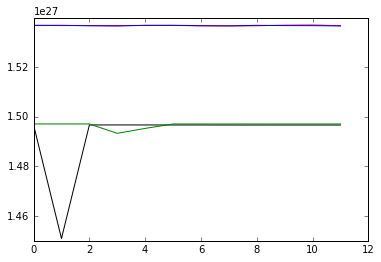

In [60]:
plt.plot(average_temp['historical'].data, color='black')
plt.plot(average_temp['historicalGHG'].data, color='red')
plt.plot(average_temp['historicalMisc'].data, color='blue')
plt.plot(average_temp['piControl'].data, color='green')

#plt.ylim(3.75e20, 3.76e20)

plt.show()